In [1]:
import sys
import matplotlib.pyplot as plt
import time
import numpy as np
from pca_classifier import make_figures
from pca_classifier import load_data
from pca_classifier import prepare_data
from pca_classifier import estimate_covariance as cov_est
from pca_classifier import classify
from functools import partial
import os
import pickle

In [2]:
dataset   = 'mnist'
prep_type = 'noise'
sigma     = 0.05
threshhold= 1e-8
estimator = 'LW'
n_comps   = [8,16,32,64,128,256,512,28*28]
output_dir= '../outputs/'

In [3]:
results = {}

In [4]:
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

In [5]:
label = dataset+'_'+prep_type+'_'+estimator

In [6]:
if prep_type=='noise':
    prep_data = partial(prepare_data.inpaint_low_var_pixels,noise_level=sigma)
elif prep_type=='mask':
    prep_data = partial(prepare_data.inpaint_low_var_pixels)

In [7]:
if dataset=='mnist':
    x_train, targets_train, x_test, targets_test = load_data.load_mnist('../data/')
elif dataset=='fmnist':
    x_train, targets_train, x_test, targets_test = load_data.load_fmnist('../data/')

In [8]:
num_classes = len(np.unique(targets_train))
print(num_classes)

10


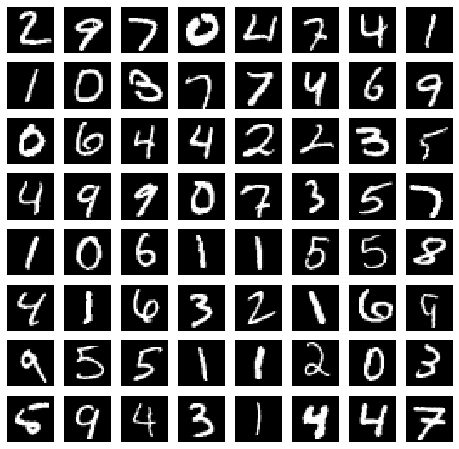

In [9]:
make_figures.make_plots(x_test,'mnist')

In [10]:
train_data = {}
test_data  = {}
for ii in range(num_classes):
    indices = np.where(targets_train==ii)
    train_data[str(ii)]=x_train[indices]
    indices = np.where(targets_test==ii)
    test_data[str(ii)]=x_test[indices]

In [11]:
train_data_prep = {}
shapes = {}
for ii in range(num_classes):
    train_data_prep[str(ii)]=prep_data(train_data[str(ii)],threshhold=threshhold)
    shapes[str(ii)]=train_data_prep[str(ii)][0].shape[0]

In [12]:
covs = {}
for ii in range(num_classes):
    try:
        cov_est.load_covariance(output_dir,label+str(ii),mode)
    except:
        covs[str(ii)] = cov_est.CovarianceEstimator(mode=estimator)
        covs[str(ii)].fit(train_data_prep[str(ii)],label+str(ii))
        covs[str(ii)].decompose()
        covs[str(ii)].save(output_dir)

0
1
2
3
4
5
6
7
8
9


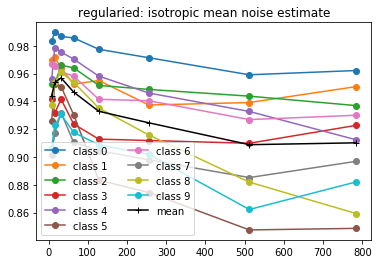

In [13]:
Cinvs = {}
logdetCs = {}
for ii in range(num_classes):
    Cinvs[str(ii)]={}
    logdetCs[str(ii)]={}
    print(ii)
    for nn in n_comps:
        Cinv, logdetC              = cov_est.get_covariance(covs[str(ii)].R,covs[str(ii)].vars,num=nn,N=None,reg=True)
        Cinvs[str(ii)][str(nn)]    = Cinv
        logdetCs[str(ii)][str(nn)] = logdetC
        
"""-------------------------------------------------"""

acc    = np.zeros((len(n_comps),num_classes))

for n, nn in enumerate(n_comps):
    """
    looping over number of components
    """
    
    for jj in range(num_classes):
        """
        looping over classes
        """ 
        size   = len(test_data[str(jj)])
        px     = np.zeros((num_classes,size))
        for ii in range(num_classes):
            """
            looping over models
            """  
            data = prep_data(test_data[str(jj)],train_data[str(ii)],threshhold=threshhold)
            
            logdet = logdetCs[str(ii)][str(nn)]            
            Cinv   = Cinvs[str(ii)][str(nn)]
            mean   = covs[str(ii)].mean
            
            px[ii]  = classify.get_data_space_log_prob(data,logdet,Cinv,mean,vol=True)
        acc[n][jj]  = len(np.where(np.argsort(px,axis=0)[-1]==jj)[0])/np.float(size)
     
"""-------------------------------------------------"""
plt.figure()
plt.title('regularied: isotropic mean noise estimate')
means = np.mean(acc,axis=1)
for ii in range(num_classes):
    plt.plot(n_comps,acc[:,ii],marker='o',label='class %d'%ii)
plt.plot(n_comps,means,marker='+',color='black',label='mean')
plt.legend(ncol=2)
plt.show()

results['mean_regularized'] = means

0
1
2
3
4
5
6
7
8
9


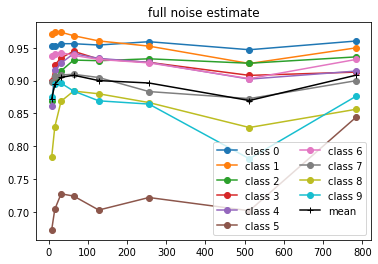

In [14]:
Cinvs = {}
logdetCs = {}
for ii in range(num_classes):
    Cinvs[str(ii)]={}
    logdetCs[str(ii)]={}
    print(ii)
    for nn in n_comps:
        N                          = covs[str(ii)].get_N(train_data_prep[str(ii)],nn)
        Cinv, logdetC              = cov_est.get_covariance(covs[str(ii)].R,covs[str(ii)].vars,num=nn,N=N,reg=True)
        Cinvs[str(ii)][str(nn)]    = Cinv
        logdetCs[str(ii)][str(nn)] = logdetC
        
"""-------------------------------------------------"""

acc    = np.zeros((len(n_comps),num_classes))

for n, nn in enumerate(n_comps):
    """
    looping over number of components
    """
    
    for jj in range(num_classes):
        """
        looping over classes
        """ 
        size   = len(test_data[str(jj)])
        px     = np.zeros((num_classes,size))
        for ii in range(num_classes):
            """
            looping over models
            """  
            data = prep_data(test_data[str(jj)],train_data[str(ii)],threshhold=threshhold)
            
            logdet = logdetCs[str(ii)][str(nn)]            
            Cinv   = Cinvs[str(ii)][str(nn)]
            mean   = covs[str(ii)].mean
            
            px[ii]  = classify.get_data_space_log_prob(data,logdet,Cinv,mean,vol=True)
        acc[n][jj]  = len(np.where(np.argsort(px,axis=0)[-1]==jj)[0])/np.float(size)
     
"""-------------------------------------------------"""
plt.figure()
plt.title('full noise estimate')
means = np.mean(acc,axis=1)
for ii in range(num_classes):
    plt.plot(n_comps,acc[:,ii],marker='o',label='class %d'%ii)
plt.plot(n_comps,means,marker='+',color='black',label='mean')
plt.legend(ncol=2)
plt.show()

results['full_regularized'] = means

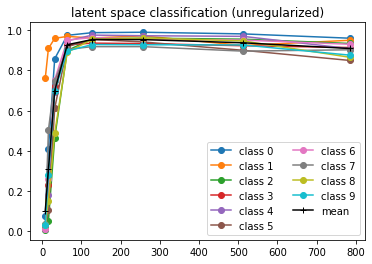

In [15]:
## latent space classification
        
"""-------------------------------------------------"""

acc    = np.zeros((len(n_comps),num_classes))

for n, nn in enumerate(n_comps):
    """
    looping over number of components
    """
    
    for jj in range(num_classes):
        """
        looping over classes
        """ 
        size   = len(test_data[str(jj)])
        px     = np.zeros((num_classes,size))
        for ii in range(num_classes):
            """
            looping over models
            """  
            data    = prep_data(test_data[str(jj)],train_data[str(ii)],threshhold=threshhold)
            px[ii]  = classify.get_latent_space_log_prob(data,covs[str(ii)],n_comp=nn,vol=True)
        acc[n][jj]  = len(np.where(np.argsort(px,axis=0)[-1]==jj)[0])/np.float(size)
     
"""-------------------------------------------------"""
plt.figure()
plt.title('latent space classification (unregularized)')
means = np.mean(acc,axis=1)
for ii in range(num_classes):
    plt.plot(n_comps,acc[:,ii],marker='o',label='class %d'%ii)
plt.plot(n_comps,means,marker='+',color='black',label='mean')
plt.legend(ncol=2)
plt.show()

results['latent_space'] = means

In [16]:
outputfile = os.path.join(output_dir,'results_'+label+'.pkl')
pickle.dump(results,open(outputfile,'wb'))

In [17]:
results

{'mean_regularized': array([0.94426   , 0.95366974, 0.9569408 , 0.94672998, 0.93290484,
        0.92459212, 0.90887292, 0.9102126 ]),
 'full_regularized': array([0.87190567, 0.8944641 , 0.90490004, 0.90812861, 0.8999937 ,
        0.89630919, 0.86962456, 0.90818659]),
 'latent_space': array([0.10237746, 0.30967757, 0.69972305, 0.92784888, 0.95358446,
        0.95328293, 0.93738605, 0.90904842])}

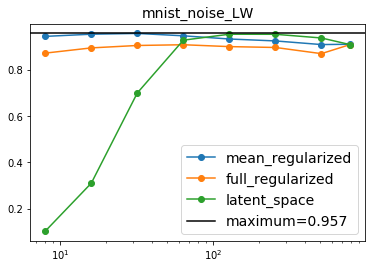

32


In [18]:
maximum = 0
x_max   = 0
plt.title(label,fontsize=14)
for item in results.keys():
    plt.semilogx(n_comps,results[item],label=item,marker='o')
    
    x_max_ = np.argsort(results[item])[-1]
    if results[item][x_max_]>maximum:
        maximum=results[item][x_max_]
        x_max  =n_comps[x_max_]
plt.axhline(maximum,color='black',label='maximum=%.3f'%maximum)
plt.legend(fontsize=14)
plt.show()
print(x_max)